In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from math import sqrt
from math import log2
import time
%matplotlib inline

# load different classifieres
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier as RFC


from sklearn.model_selection import train_test_split

# evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# preprocessing 
from sklearn.preprocessing import StandardScaler,PowerTransformer,MinMaxScaler,QuantileTransformer,normalize
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA

# for selection the right path
import os,sys,inspect,pathlib
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

# load my functions
import amazon_processor
import amazon_classificators

from common import misc
from common.data_parser import *
from common.model_trainer import *
from common.misc import *
from config import *
from common.plotting import *

In [2]:
module_path = pathlib.Path(os.getcwd()).parent
if str(module_path) not in sys.path:
    sys.path.append(str(module_path))
print(sys.path)

from common.dataset_grabber import get_data_path

['/home/alexander/Dokumente/WS2020/MaschinLearning/ML_2020/Ex1', '/home/alexander/Dokumente/WS2020/MaschinLearning/ML_2020/Ex1', '/home/alexander/Dokumente/WS2020/MaschinLearning/ML_2020/Ex1/amazon', '', '/home/alexander/ngsuite/ngsolve-install/lib/python3/dist-packages', '/home/alexander/ngsuite/ngsolve-install/bin', '/home/alexander/.local/bin', '/usr/local/sbin', '/usr/local/bin', '/usr/sbin', '/usr/bin', '/sbin', '/bin', '/usr/games', '/usr/local/games', '/snap/bin', '/home/alexander/.vscode/extensions/ms-toolsai.jupyter-2020.11.358541065/pythonFiles', '/home/alexander/.vscode/extensions/ms-toolsai.jupyter-2020.11.358541065/pythonFiles/lib/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/home/alexander/.local/lib/python3.7/site-packages', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/home/alexander/.local/lib/python3.7/site-packages/IPython/extensions', '/home/alexander/.ipython']


In [3]:
datapath_train = get_data_path("Amazon_Review_Data", "amazon_review_ID.shuf.lrn.csv")
display(datapath_train)
datapath_test = get_data_path("Amazon_Review_Data", "amazon_review_ID.shuf.tes.csv")
display(datapath_test)

PosixPath('/home/alexander/Dokumente/WS2020/MaschinLearning/ML_2020/Ex1/Datasets/Amazon_Review_Data/amazon_review_ID.shuf.lrn.csv')

PosixPath('/home/alexander/Dokumente/WS2020/MaschinLearning/ML_2020/Ex1/Datasets/Amazon_Review_Data/amazon_review_ID.shuf.tes.csv')

In [4]:
df_train = pd.read_csv(datapath_train).drop("ID",axis = 1)
df_test = pd.read_csv(datapath_test).drop("ID",axis = 1)

df_train

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V9992,V9993,V9994,V9995,V9996,V9997,V9998,V9999,V10000,Class
0,8,6,10,6,7,2,2,2,3,2,...,1,0,0,0,0,0,0,0,0,Chell
1,13,1,13,9,8,8,2,3,2,4,...,4,1,2,1,0,1,0,0,0,Engineer
2,16,7,6,7,9,3,4,2,6,5,...,0,0,0,0,1,0,0,0,0,Grove
3,8,11,10,11,3,7,0,4,2,1,...,0,0,1,0,0,0,2,1,0,Davisson
4,10,11,8,5,3,4,2,5,5,4,...,0,0,0,0,0,0,0,0,0,Wilson
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,9,8,5,5,6,2,14,1,4,5,...,0,1,0,0,1,0,1,0,0,Riley
746,6,13,4,6,8,2,7,3,3,2,...,0,0,0,0,1,0,0,0,1,Neal
747,16,11,4,9,9,4,0,3,5,0,...,0,0,0,0,0,1,1,0,4,Messick
748,9,5,4,2,3,7,2,7,1,1,...,0,0,0,0,0,2,0,0,0,Mitchell


In [5]:
feature = df_train.loc[:,'V1':'V10000']
target = df_train.loc[:,'Class':'Class']

In [6]:
pd.unique(target.Class)

array(['Chell', 'Engineer', 'Grove', 'Davisson', 'Wilson', 'Brody',
       'Lovitt', 'Vision', 'Morrison', 'Nigam', 'Johnson', 'Koenig',
       'Mitchell', 'Ashbacher', 'McKee', 'Robert', 'Calvinnme', 'Goonan',
       'Peterson', 'Vernon', 'Merritt', 'Riley', 'Walters', 'Agresti',
       'Lee', 'Kolln', 'Lawyeraau', 'Shea', 'Power', 'Chachra', 'Harp',
       'Chandler', 'Auken', 'Neal', 'Mark', 'Cholette', 'Blankenship',
       'Janson', 'Hayes', 'Taylor', 'Sherwin', 'Bukowsky', 'Corn', 'Dent',
       'Messick', 'Mahlers2nd', 'CFH', 'Cutey', 'Comdet', 'Brown'],
      dtype=object)

# Training

In [7]:
#import time
#results = pd.DataFrame(columns=["Model", "Feature_Selector", "k", "Scaler", "Score", "Trainingstime", "Fittime"])
#results = pd.DataFrame(params)
#model = ["Knn","MLP","RM"]
#score_list = []
#kn = [10,30,60,90,100,120,140,200,300,400,500,600,750]
#selector = ["kBest","PCA"]
#scale = ["standard","minmax","quantil"]
#scale = ["standard"]
#max_k = 10
#for mod in model:
#    print("\t")
#    for sel in selector:
#        for k in kn:
#            for scl in scale:           
#                df_prep = amazon_processor.Preprocessing_Amazon(feature, target,feature_method = sel,scale_method = scl, k = k)
#                X_train, X_valid, Y_train, Y_valid = train_test_split(df_prep, target, test_size=.4)
#                if (mod == "RM"):
#                    start = time.time()
#                    #clf = RFC(n_jobs=4, n_estimators=2000, max_features=0.02,bootstrap=True, oob_score=True, max_depth=60, min_samples_leaf=4, min_samples_split=4)
#                    clf = RFC()
#                    end = time.time()
#                    train_time = end - start
#                if (mod == "MLP"):
#                    start = time.time()
#                    #clf = MLP(hidden_layer_sizes=(h),alpha=0.1,activation="relu",solver="adam",max_iter=200)
#                    clf = MLP()
#                    end = time.time()
#                    train_time = end - start
#                if (mod == "Knn"):
#                    score_list = []
#                    for knn in range(1, max_k):
#                        model = KNN(n_neighbors=knn).fit(X_train, Y_train)
#                        Y_pred = model.predict(X_valid)
#                        score = accuracy_score(Y_valid, Y_pred)
#                        score_list.append(score)
#                    knn = score_list.index(max(score_list))+1
#
#                    start = time.time()
#                    clf = KNN(n_neighbors=knn).fit(X_train, Y_train)
#                    end = time.time()
#                    train_time = end - start
#                       
#
#                start = time.time()
#                clf.fit(X_train, Y_train)
#                end = time.time()
#                fit_time = end - start
#
#                Y_pred = clf.predict(X_valid)
#                score = accuracy_score(Y_valid, Y_pred)
#                print("Model: ",mod, "score: ",score,"k: ",k,"scaler: ",scl, "selector: ",sel)
#                print("Model: ",mod, "Traintime: ",train_time,"fit_time: ",fit_time)
#                results = results.append({'Model': mod, "Feature_Selector": sel, "k": k, "Scaler": scl, "Score": score, "Trainingstime": train_time, "Fittime": fit_time}, ignore_index=True)

In [8]:
results = pd.read_csv("out/expensive_results_amazon_original.csv")

In [9]:
results

,Model,Feature_Selector,k,Scaler,Score,Trainingstime,Fittime
0,Knn,kBest,10,standard,0.120000,0.003697,0.003551
1,Knn,kBest,10,minmax,0.126667,0.003639,0.004522
2,Knn,kBest,10,quantil,0.106667,0.003639,0.004097
3,Knn,kBest,30,standard,0.246667,0.005395,0.004386
4,Knn,kBest,30,minmax,0.240000,0.004190,0.003933
...,...,...,...,...,...,...,...
229,RM,PCA,600,minmax,0.100000,0.000360,2.780700
230,RM,PCA,600,quantil,0.106667,0.000180,2.791843
231,RM,PCA,750,standard,0.070000,0.000352,3.420233
232,RM,PCA,750,minmax,0.063333,0.000325,3.448179


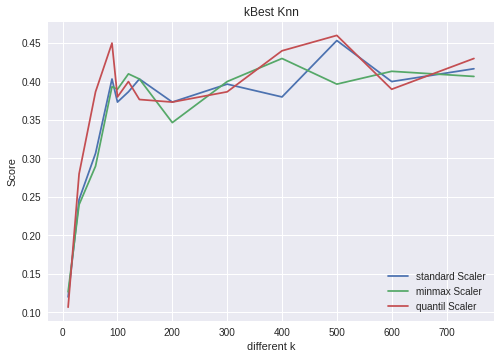

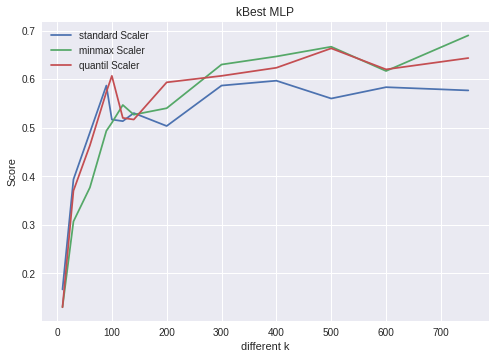

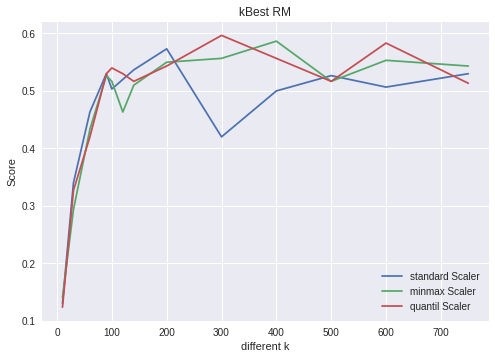

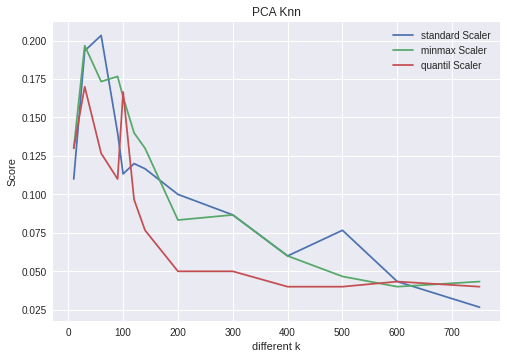

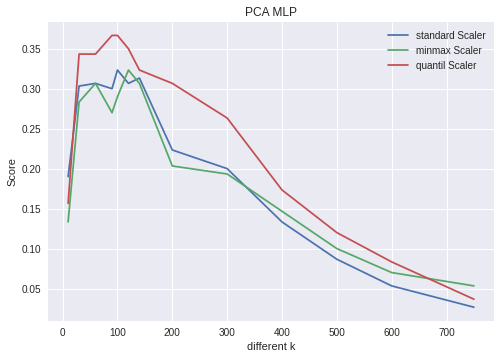

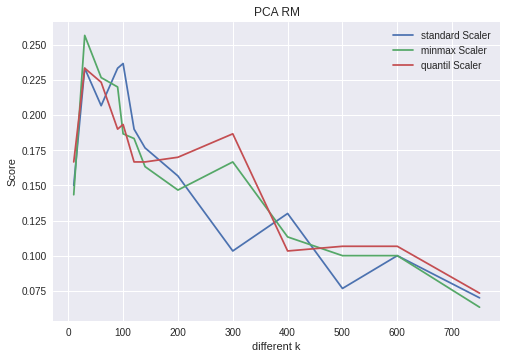

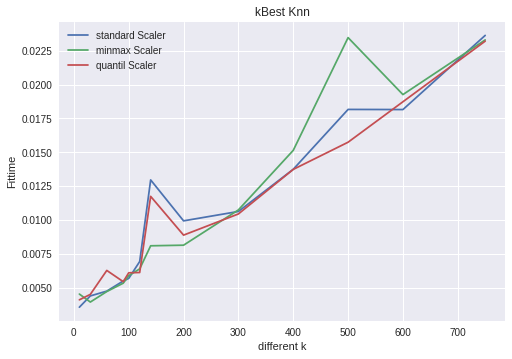

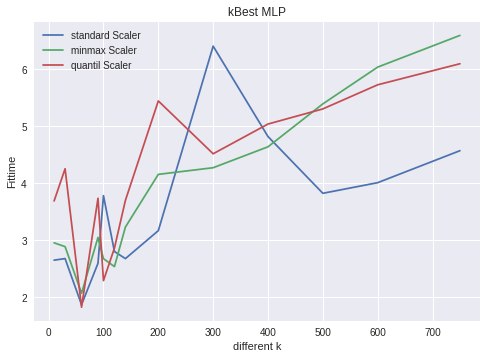

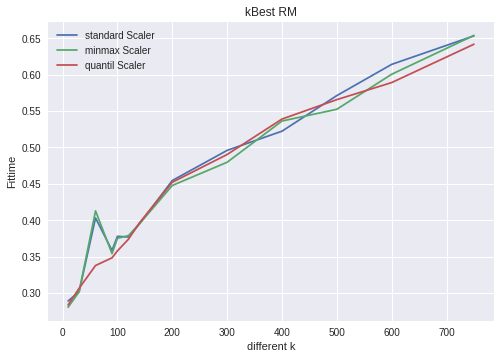

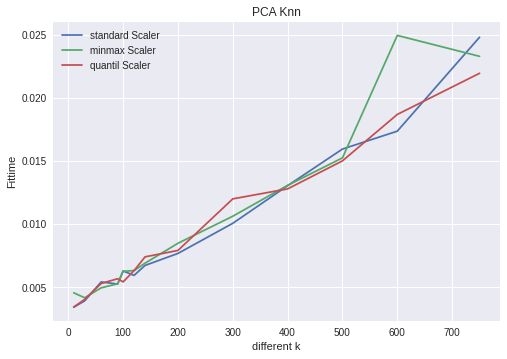

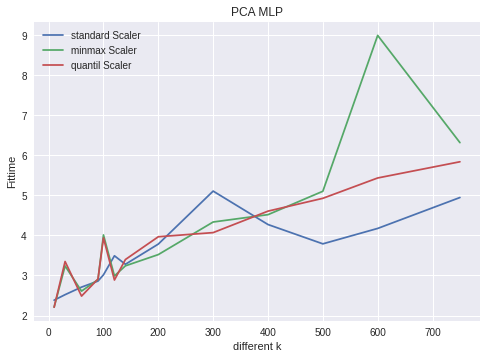

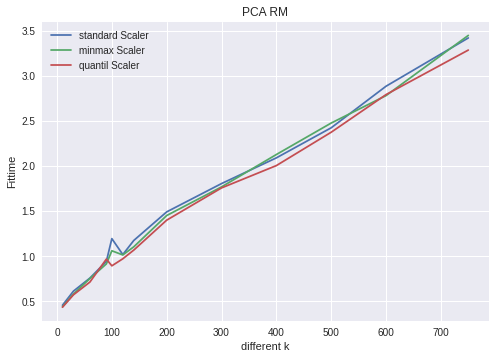

In [10]:
Scaler = ["standard", "minmax", "quantil"]
Model = ["Knn", "MLP", "RM"]
Feature_Selector = ["kBest", "PCA"]
kind = ["Score", "Fittime"]
for ki in kind:
    for feat in Feature_Selector:
        for mod in Model:
            amazon_processor.Plot_preprocessing(results, feat, Scaler, mod, ki)

# MLP Classifierer

In [11]:
MODEL = MLP
MODEL_TYPE = "MLP"
params = {
    "alpha" : [1e-3,1e-2,1e-1,1,1e1], 
    "hidden_layer_sizes" : [(20,20),(50,50),(100,100)],
    "solver" : ["adam","lbfgs"],
    "activation" : ["tanh", "relu"]
    }
SCORES = "accuracy"
OUT_DIR = f"out/{MODEL_TYPE}/"

fname = OUT_DIR + f"{MODEL_TYPE}_{SCORES}.pdf"

In [12]:
k, scl = amazon_processor.FindBestK_Scaler(results, "MLP")

df_prep = amazon_processor.Preprocessing_Amazon(feature, target,feature_method = "kBest",scale_method = scl.values[0], k = k.values[0])
X_train, X_valid, Y_train, Y_valid = train_test_split(df_prep, target, test_size=0.4, random_state = 42)

In [13]:
LOGX = True
YLIMS = (0.5, 1)


def plot_params(results, scores="score", fileName=None, params=params, ylims=YLIMS):
    param_keys = list(params)
    first_key = param_keys[0]
    rest = param_keys[1:]

    plt.style.use('seaborn')
    if isinstance(scores, str):
        fix, ax = plt.subplots(figsize=(8,6))
        for vals in tuple(itertools.product(*tuple(x for x in tuple(params.values())[1:]))):
            label = " / ".join([str(x) for x in vals])
            filters = " & ".join([str(x)+' == "'+str(v)+'"' for x, v in zip(rest, vals)])
            results.query(filters).plot(
                x=first_key, y=scores, label=label,
                    ax=ax, marker="o", logx=LOGX);
        plt.legend()
        ax.set_title(scores, fontsize=18)

        plt.ylim(*ylims)
        if fileName:
            plt.savefig(fileName)
        plt.show()
        return plt.gcf() 

In [14]:
modeltrainer = ModelTrainer(
    MODEL, 
    params, 
    X_train, Y_train, X_valid, Y_valid, 
    accuracy_score,
    thread_cnt=8
    )
modeltrainer.train()
modeltrainer.save_result("out/mlp_params.csv")
result_MLP = modeltrainer.result

Finished evaluation
Best parameteters found with: {'alpha': 0.1, 'hidden_layer_sizes': (100, 100), 'solver': 'adam', 'activation': 'tanh'}
score= (0.62, 0.62)
Total evaluation time = 238.13s


In [15]:
result_MLP[result_MLP["score"] == np.max(result_MLP["score"])]

,alpha,hidden_layer_sizes,solver,activation,train_time,inference_time,score,accuracy,f1,recall,precision
32,0.1,"(100, 100)",adam,tanh,56.897013,0.075816,0.62,0.62,0.603723,0.630143,0.647558


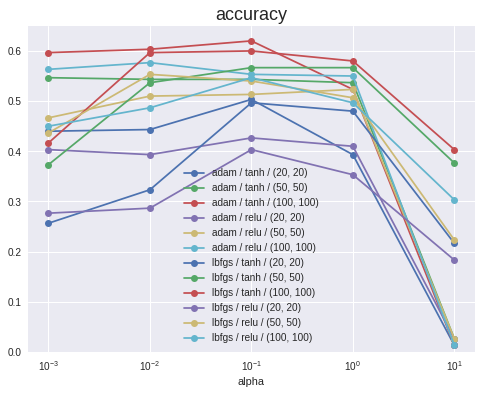

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

In [16]:
SCORES = "accuracy"
OUT_DIR = f"out/{MODEL_TYPE}/"
fname = OUT_DIR + f"{MODEL_TYPE}_{SCORES}.pdf"
plot_mlp(result_MLP, scores=SCORES, fileName=fname,params=params, ylims=(0,0.65))

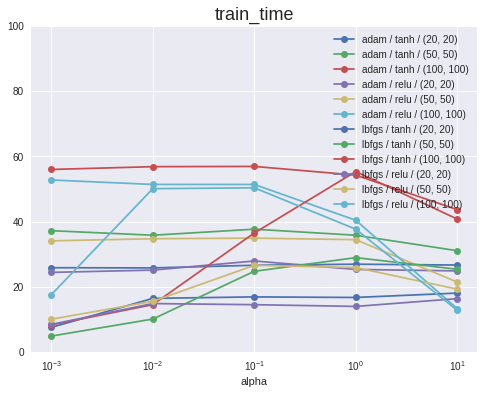

<Figure size 576x396 with 0 Axes>

<Figure size 576x396 with 0 Axes>

In [17]:
SCORES = "train_time"
OUT_DIR = f"out/{MODEL_TYPE}/"
fname = OUT_DIR + f"{MODEL_TYPE}_{SCORES}.pdf"
plot_mlp(result_MLP, scores=SCORES, fileName=fname,params=params, ylims=(0,100))

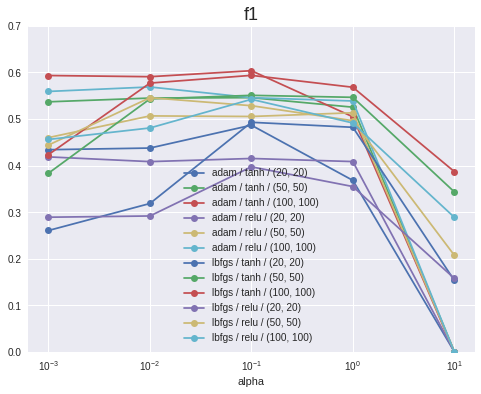

<Figure size 576x396 with 0 Axes>

In [18]:
SCORES = "f1"
OUT_DIR = f"out/{MODEL_TYPE}/"

fname = OUT_DIR + f"{MODEL_TYPE}_{SCORES}.pdf"
plot_mlp(result_MLP, scores=SCORES, fileName=fname,params=params, ylims=(0,0.7));

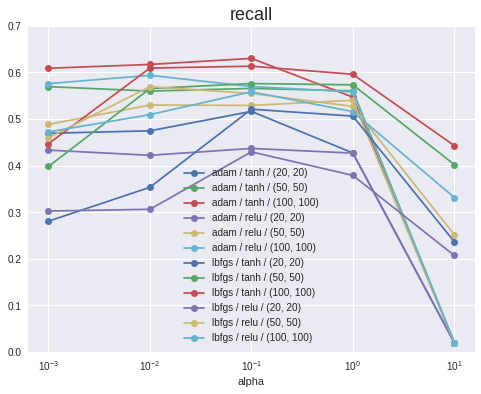

<Figure size 576x396 with 0 Axes>

In [19]:
SCORES = "recall"
OUT_DIR = f"out/{MODEL_TYPE}/"

fname = OUT_DIR + f"{MODEL_TYPE}_{SCORES}.pdf"
plot_mlp(result_MLP, scores=SCORES, fileName=fname,params=params, ylims=(0,0.7));

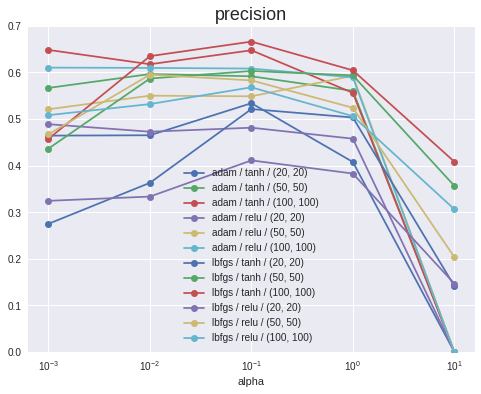

<Figure size 576x396 with 0 Axes>

In [20]:
SCORES = "precision"
OUT_DIR = f"out/{MODEL_TYPE}/"

fname = OUT_DIR + f"{MODEL_TYPE}_{SCORES}.pdf"
plot_mlp(result_MLP, scores=SCORES, fileName=fname,params=params, ylims=(0,0.7));

In [21]:
df_results_MLP = pd.read_csv("out/mlp_params.csv")

# KNN Classifierer

In [22]:
MODEL = KNN
MODEL_TYPE = "KNN"
params = {
    "n_neighbors" : list(range(1, 200)), 
    "weights" : ["uniform", "distance"],
    "algorithm" : ["auto", "ball_tree", "kd_tree", "brute"]
    }

SCORES = "accuracy"
OUT_DIR = f"out/{MODEL_TYPE}/"

fname = OUT_DIR + f"{MODEL_TYPE}_{SCORES}.pdf"

In [23]:
k, scl = amazon_processor.FindBestK_Scaler(results, "Knn")

df_prep = amazon_processor.Preprocessing_Amazon(feature, target,feature_method = "kBest",scale_method = scl.values[0], k = k.values[0])
X_train, X_valid, Y_train, Y_valid = train_test_split(df_prep, target, test_size=.4, random_state = 42)

In [24]:
modeltrainer = ModelTrainer(
    MODEL, 
    params, 
    X_train, Y_train, X_valid, Y_valid, 
    accuracy_score,
    thread_cnt=8
    )
modeltrainer.train()
modeltrainer.save_result("out/knn_params.csv")
result_KNN = modeltrainer.result

Finished evaluation
Best parameteters found with: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'auto'}
score= (0.47333333333333333, 0.47333333333333333)
Total evaluation time = 100.65s


In [25]:
result_KNN[result_KNN["score"] == np.max(result_KNN["score"] )]

,n_neighbors,weights,algorithm,train_time,inference_time,score,accuracy,f1,recall,precision
60,8,distance,auto,0.068755,0.672434,0.473333,0.473333,0.455699,0.489984,0.53743
61,8,distance,ball_tree,0.034406,0.421268,0.473333,0.473333,0.455699,0.489984,0.53743
62,8,distance,kd_tree,0.065364,0.561241,0.473333,0.473333,0.455699,0.489984,0.53743
63,8,distance,brute,0.010691,0.031356,0.473333,0.473333,0.455699,0.489984,0.53743


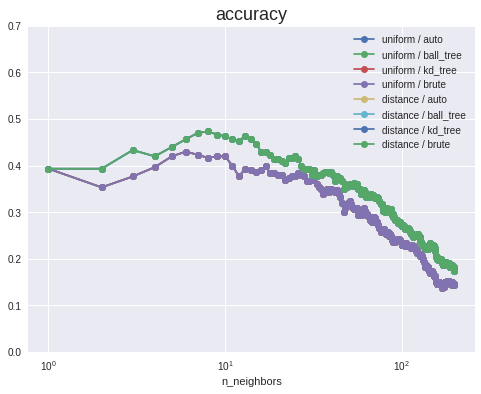

<Figure size 576x396 with 0 Axes>

In [26]:
SCORES = "accuracy"
plot_params(result_KNN, scores=SCORES, fileName=fname,params=params, ylims=(0,0.7));

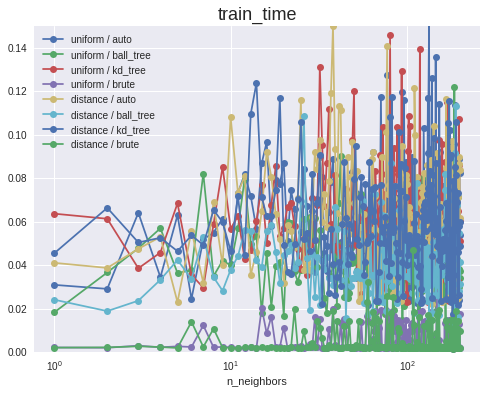

<Figure size 576x396 with 0 Axes>

In [27]:
SCORES = "train_time"
OUT_DIR = f"out/{MODEL_TYPE}/"

fname = OUT_DIR + f"{MODEL_TYPE}_{SCORES}.pdf"
plot_params(result_KNN, scores=SCORES, fileName=fname,params=params, ylims=(0,0.15));

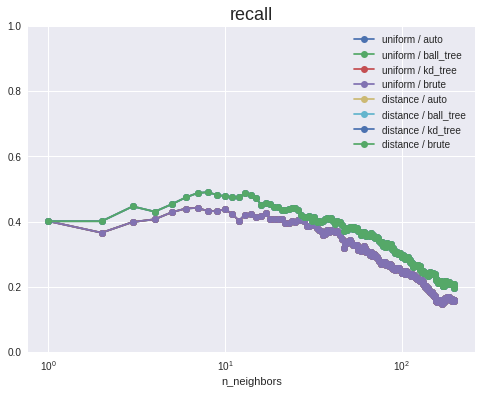

<Figure size 576x396 with 0 Axes>

In [28]:
SCORES = "recall"
OUT_DIR = f"out/{MODEL_TYPE}/"

fname = OUT_DIR + f"{MODEL_TYPE}_{SCORES}.pdf"
plot_params(result_KNN, scores=SCORES, fileName=fname,params=params, ylims=(0,1));

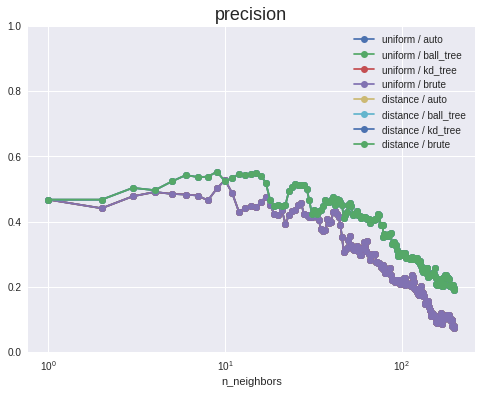

<Figure size 576x396 with 0 Axes>

In [29]:
SCORES = "precision"
OUT_DIR = f"out/{MODEL_TYPE}/"

fname = OUT_DIR + f"{MODEL_TYPE}_{SCORES}.pdf"
plot_params(result_KNN, scores=SCORES, fileName=fname,params=params, ylims=(0,1));

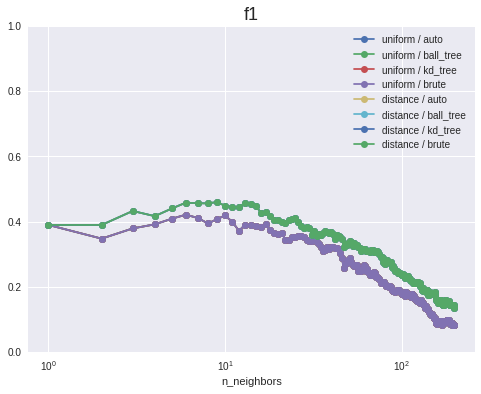

<Figure size 576x396 with 0 Axes>

In [30]:
SCORES = "f1"
OUT_DIR = f"out/{MODEL_TYPE}/"

fname = OUT_DIR + f"{MODEL_TYPE}_{SCORES}.pdf"
plot_params(result_KNN, scores=SCORES, fileName=fname,params=params, ylims=(0,1));

In [31]:
df_results_KNN = pd.read_csv("out/knn_params.csv")

# RandomForrest classifierer

In [32]:
MODEL = RFC
MODEL_TYPE = "RFC"
params = {
    "n_estimators": [1, 8, 10, 12, 15, 20, 50, 100,  1000],
    "max_features": ["sqrt", "log2"],
    "criterion": ["gini", "entropy"]
}
SCORES = "accuracy"
OUT_DIR = f"out/{MODEL_TYPE}/"

fname = OUT_DIR + f"{MODEL_TYPE}_{SCORES}.pdf"

In [33]:
k, scl = amazon_processor.FindBestK_Scaler(results, "RM")

df_prep = amazon_processor.Preprocessing_Amazon(feature, target,feature_method = "kBest",scale_method = scl.values[0], k = k.values[0])
X_train, X_valid, Y_train, Y_valid = train_test_split(df_prep, target, test_size=.4, random_state = 42)

In [34]:
modeltrainer = ModelTrainer(
    MODEL, 
    params, 
    X_train, Y_train, X_valid, Y_valid, 
    accuracy_score,
    thread_cnt=8
    )
modeltrainer.train()
modeltrainer.save_result("out/rf_params.csv")
result_RFC = modeltrainer.result

Finished evaluation
Best parameteters found with: {'n_estimators': 1000, 'max_features': 'sqrt', 'criterion': 'gini'}
score= (0.5933333333333334, 0.5933333333333334)
Total evaluation time = 15.19s


In [35]:
df_results_RFC = pd.read_csv("out/rf_params.csv")

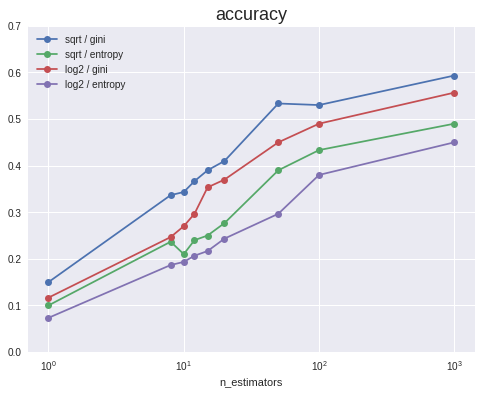

<Figure size 576x396 with 0 Axes>

In [36]:
SCORES = "accuracy"
plot_params(result_RFC, scores=SCORES, fileName=fname,params=params, ylims=(0,0.7));

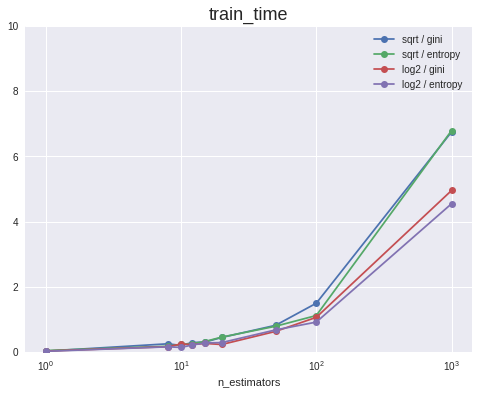

<Figure size 576x396 with 0 Axes>

In [37]:
SCORES = "train_time"
OUT_DIR = f"out/{MODEL_TYPE}/"

fname = OUT_DIR + f"{MODEL_TYPE}_{SCORES}.pdf"
plot_params(result_RFC, scores=SCORES, fileName=fname,params=params, ylims=(0,10));

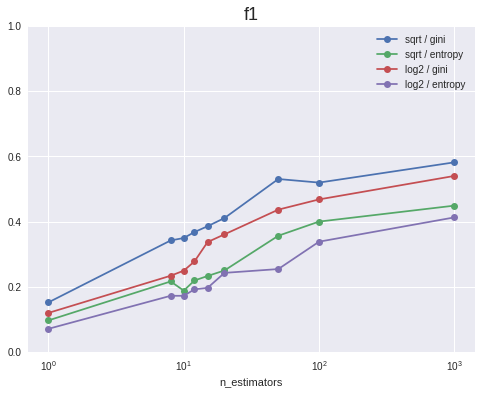

<Figure size 576x396 with 0 Axes>

In [38]:
SCORES = "f1"
OUT_DIR = f"out/{MODEL_TYPE}/"

fname = OUT_DIR + f"{MODEL_TYPE}_{SCORES}.pdf"
plot_params(result_RFC, scores=SCORES, fileName=fname,params=params, ylims=(0,1));

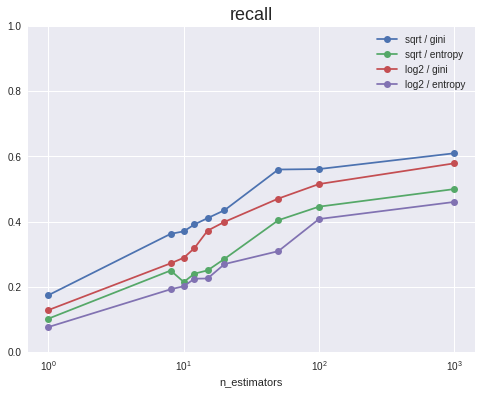

<Figure size 576x396 with 0 Axes>

In [39]:
SCORES = "recall"
OUT_DIR = f"out/{MODEL_TYPE}/"

fname = OUT_DIR + f"{MODEL_TYPE}_{SCORES}.pdf"
plot_params(result_RFC, scores=SCORES, fileName=fname,params=params, ylims=(0,1));

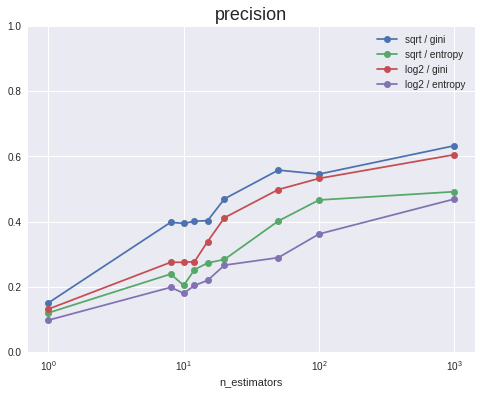

<Figure size 576x396 with 0 Axes>

In [40]:
SCORES = "precision"
OUT_DIR = f"out/{MODEL_TYPE}/"

fname = OUT_DIR + f"{MODEL_TYPE}_{SCORES}.pdf"
plot_params(result_RFC, scores=SCORES, fileName=fname,params=params, ylims=(0,1));

# Filepreparation for the kagglecompetition

In [41]:
df_train = pd.read_csv(datapath_train).drop("ID",axis = 1)
df_test = pd.read_csv(datapath_test).drop("ID",axis = 1)

feature = df_train.loc[:,'V1':'V10000']
target = df_train.loc[:,'Class':'Class']

scaler = StandardScaler().fit(feature)
df_train_SC = scaler.transform(feature)


scaler = StandardScaler().fit(df_test)
df_test_SC = scaler.transform(df_test)

In [42]:
#Best parameteters found with: {'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'solver': 'adam', 'activation': 'tanh'}
df_test = pd.read_csv(datapath_test).drop("ID",axis = 1)
k, scl = amazon_processor.FindBestK_Scaler(results, "MLP")

df_test_prep = amazon_processor.Preprocessing_Amazon(df_test, target,feature_method = "kBest",scale_method = scl.values[0], k = k.values[0])


clf = MLP(hidden_layer_sizes=(50,50),alpha=0.001,activation='tanh',solver='adam')
clf.fit(df_test_prep,target)
LC = clf.loss_curve_
Y_pred = clf.predict(df_test_prep)

In [43]:
solution_data = list(zip(list(range(750,1500)), Y_pred))

In [44]:
solution_table = pd.DataFrame(solution_data, columns=['ID', 'Class'])
solution_table.Class

0         Chell
1      Engineer
2         Grove
3      Davisson
4        Wilson
         ...   
745       Riley
746        Neal
747     Messick
748    Mitchell
749      Comdet
Name: Class, Length: 750, dtype: object

In [45]:
solution_table.to_csv(f"results/RFC_besser_SC.csv", index=False)

In [46]:
solution_table

,ID,Class
0,750,Chell
1,751,Engineer
2,752,Grove
3,753,Davisson
4,754,Wilson
...,...,...
745,1495,Riley
746,1496,Neal
747,1497,Messick
748,1498,Mitchell
